In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

In [2]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # match CIFAR10-like CNN
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
])

In [4]:
data_dir = "data"   # CHANGE path if needed
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_data, test_data = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=64, shuffle=False)

class_names = dataset.classes
num_classes = len(class_names)
print("Classes:", class_names)

Classes: ['bike', 'cars', 'cats', 'data', 'dogs', 'flowers', 'horses', 'human']


In [5]:
class cnn_custom(nn.Module):
    def __init__(self, num_classes):
        super(cnn_custom, self).__init__()
        self.cnn1 = nn.Conv2d(3, 6, 5)
        self.cnn2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)
        
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = torch.max_pool2d(x, 2)

        x = self.cnn2(x)
        x = torch.relu(x)
        x = torch.max_pool2d(x, 2)

        x = x.flatten(1)  
        x = self.fc1(x)
        x = torch.relu(x)

        x = self.fc2(x)
        x = torch.relu(x)

        x = self.fc3(x)
        return x

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = cnn_custom(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(5):  # reduce to 5 for speed
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/5], Loss: {running_loss/len(train_loader):.4f}")

Epoch [1/5], Loss: 1.7715
Epoch [2/5], Loss: 1.6703
Epoch [3/5], Loss: 1.6171
Epoch [4/5], Loss: 1.5469
Epoch [5/5], Loss: 1.4710


In [7]:
# --------------------------
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, pred = torch.max(outputs, 1)
        correct += (pred == labels).sum().item()
        total += labels.size(0)

print(f"✅ Test Accuracy: {100 * correct / total:.2f}%")

✅ Test Accuracy: 49.17%


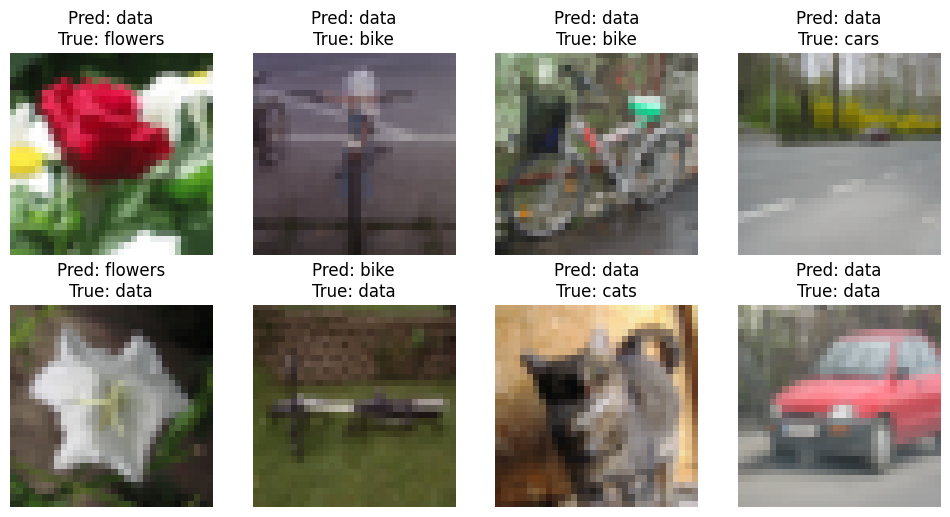

In [12]:
import matplotlib.pyplot as plt
import numpy as np
def imshow(img, title):
    img = img / 2 + 0.5   # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis("off")

# Get some random test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Predict
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, preds = torch.max(outputs, 1)

# Plot first 8 test images
plt.figure(figsize=(12,6))
for idx in range(8):
    plt.subplot(2, 4, idx+1)
    imshow(images[idx].cpu(), f"Pred: {class_names[preds[idx]]}\nTrue: {class_names[labels[idx]]}")
plt.show()